see Dayan p 15

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/steeve_laquitaine/Desktop/CARLO/code/fisher-info-limits/envs/fisher_info_limits/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/steeve_laquitaine/Desktop/CARLO/code/fisher-info-limits/envs/fisher_info_limits/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/steeve_laquitaine/Desktop/CARLO/code/fisher-info-limits/envs/fisher_info_limits/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in

Creating 30 Gaussian tuning functions on circular space...
Created 30 tuning functions
Preferred angles: [0.         0.20943951 0.41887902 0.62831853 0.83775804 1.04719755
 1.25663706 1.46607657 1.67551608 1.88495559 2.0943951  2.30383461
 2.51327412 2.72271363 2.93215314 3.14159265 3.35103216 3.56047167
 3.76991118 3.97935069 4.1887902  4.39822972 4.60766923 4.81710874
 5.02654825 5.23598776 5.44542727 5.65486678 5.86430629 6.0737458 ]


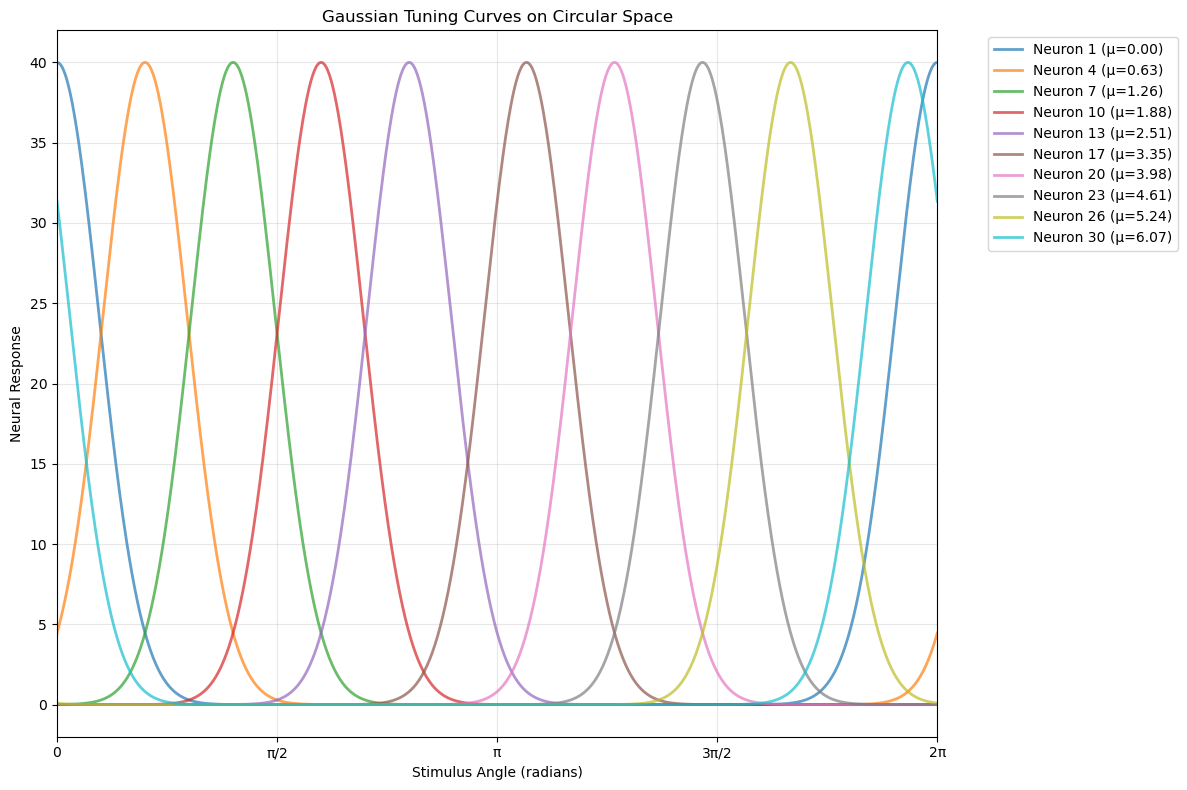

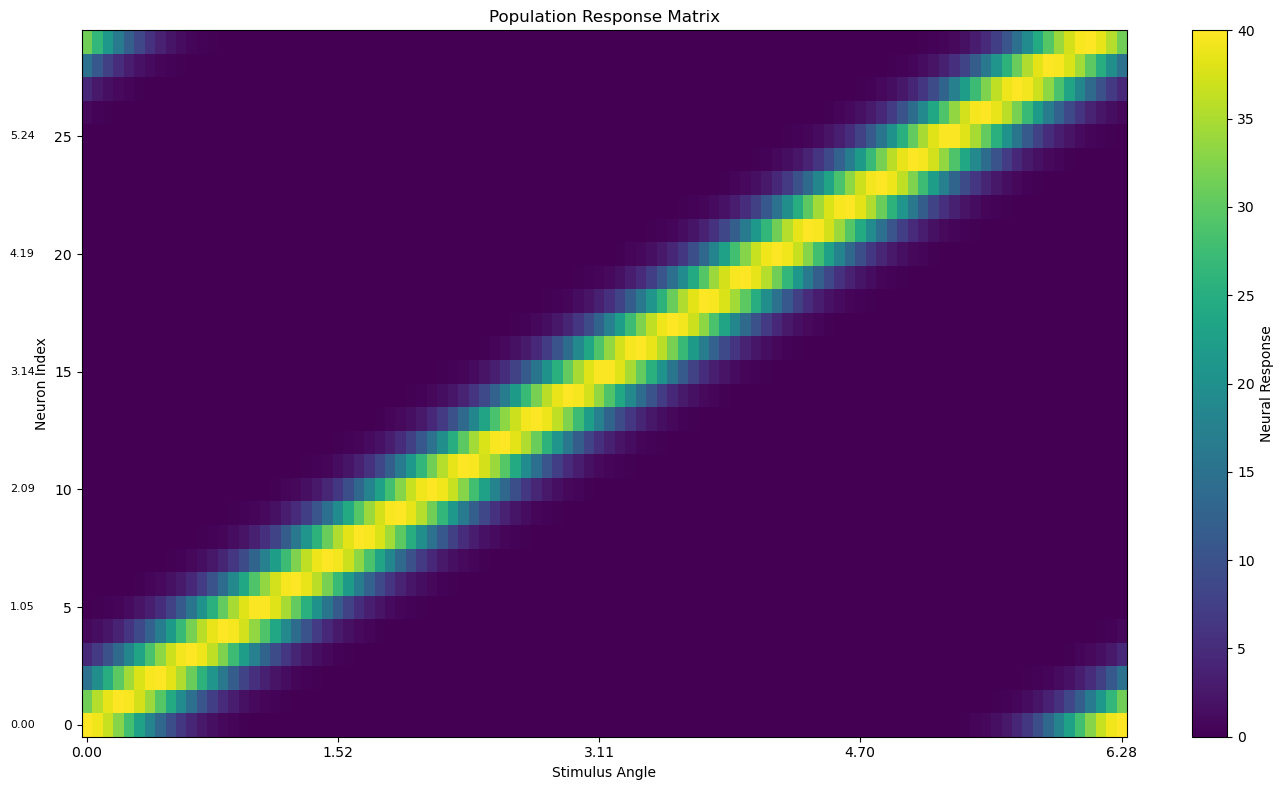


Population response to θ = 0.79 radians:
Responses: [1.29944010e+00 6.33407675e+00 1.89644614e+01 3.48760942e+01
 3.93953813e+01 2.73333530e+01 1.16485173e+01 3.04914815e+00
 4.90248800e-01 4.84155298e-02 2.93685818e-03 1.09423701e-04
 2.50420547e-06 3.52012962e-08 3.03932743e-10 1.61185682e-12
 5.25055930e-15 1.05054537e-17 1.29108309e-20 3.77005498e-22
 3.91420200e-19 2.49613990e-16 9.77743071e-14 2.35239749e-11
 3.47637650e-09 3.15553528e-07 1.75933852e-05 6.02498431e-04
 1.26733832e-02 1.63741720e-01]
Most active neuron: 4 (preferred angle: 0.84)

PyTorch version for neural network integration:
PyTorch responses shape: torch.Size([30])
PyTorch max response: 39.40
Batch responses shape: torch.Size([5, 30])
Batch processing successful!
CPU times: user 868 ms, sys: 271 ms, total: 1.14 s
Wall time: 31.9 s


In [5]:
%%time
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch

def circular_gaussian(theta, mu, sigma, amplitude=1.0):
    """
    Gaussian tuning function on circular space [0, 2π)
    
    Args:
        theta: input angle(s) in radians
        mu: preferred angle (center of tuning curve) 
        sigma: tuning width parameter
        amplitude: maximum response amplitude
    
    Returns:
        response: Gaussian response on circular space
    """
    # Calculate circular distance (shortest path on circle)
    diff = theta - mu
    # Wrap difference to [-π, π] 
    diff = np.angle(np.exp(1j * diff))
    
    # Gaussian response
    response = amplitude * np.exp(-0.5 * (diff / sigma)**2)
    return response

def create_circular_tuning_functions(n_neurons=30, sigma=0.3, amplitude=40.0):
    """
    Create a population of neurons with Gaussian tuning curves on circular space
    
    Args:
        n_neurons: number of neurons
        sigma: tuning width (smaller = sharper tuning)
        amplitude: maximum firing rate
    
    Returns:
        preferred_angles: preferred angle for each neuron
        tuning_functions: list of tuning function callables
    """
    # Evenly distribute preferred angles around the circle
    preferred_angles = np.linspace(0, 2*np.pi, n_neurons, endpoint=False)
    
    # Create tuning function for each neuron
    tuning_functions = []
    for mu in preferred_angles:
        # Create a closure that captures mu, sigma, amplitude
        def tuning_func(theta, mu=mu, sigma=sigma, amplitude=amplitude):
            return circular_gaussian(theta, mu, sigma, amplitude)
        tuning_functions.append(tuning_func)
    
    return preferred_angles, tuning_functions

def plot_tuning_curves(preferred_angles, tuning_functions, n_plot=10):
    """
    Plot a subset of the tuning curves
    """
    # Create stimulus angles for plotting
    theta_plot = np.linspace(0, 2*np.pi, 1000)
    
    plt.figure(figsize=(12, 8))
    
    # Plot subset of tuning curves
    indices_to_plot = np.linspace(0, len(tuning_functions)-1, n_plot, dtype=int)
    
    for i in indices_to_plot:
        responses = [tuning_functions[i](theta) for theta in theta_plot]
        plt.plot(theta_plot, responses, 
                label=f'Neuron {i+1} (μ={preferred_angles[i]:.2f})', 
                alpha=0.7, linewidth=2)
    
    plt.xlabel('Stimulus Angle (radians)')
    plt.ylabel('Neural Response')
    plt.title('Gaussian Tuning Curves on Circular Space')
    plt.xlim(0, 2*np.pi)
    plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], 
              ['0', 'π/2', 'π', '3π/2', '2π'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def population_response(theta, tuning_functions):
    """
    Get response of entire population to a stimulus angle
    
    Args:
        theta: stimulus angle
        tuning_functions: list of tuning functions
    
    Returns:
        responses: array of responses from all neurons
    """
    responses = np.array([f(theta) for f in tuning_functions])
    return responses

def population_response_matrix(theta_range, tuning_functions):
    """
    Get population response matrix for a range of stimulus angles
    
    Returns:
        response_matrix: (n_neurons x n_stimuli) matrix
    """
    n_neurons = len(tuning_functions)
    n_stimuli = len(theta_range)
    response_matrix = np.zeros((n_neurons, n_stimuli))
    
    for i, theta in enumerate(theta_range):
        response_matrix[:, i] = population_response(theta, tuning_functions)
    
    return response_matrix

def plot_population_heatmap(theta_range, response_matrix, preferred_angles):
    """
    Plot population response as a heatmap
    """
    plt.figure(figsize=(14, 8))
    
    plt.imshow(response_matrix, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Neural Response')
    plt.xlabel('Stimulus Angle')
    plt.ylabel('Neuron Index')
    plt.title('Population Response Matrix')
    
    # Set x-axis ticks
    n_ticks = 5
    tick_indices = np.linspace(0, len(theta_range)-1, n_ticks, dtype=int)
    tick_labels = [f'{theta_range[i]:.2f}' for i in tick_indices]
    plt.xticks(tick_indices, tick_labels)
    
    # Add preferred angles as text
    for i, mu in enumerate(preferred_angles[::5]):  # Show every 5th neuron
        plt.text(-0.05 * len(theta_range), i*5, f'{mu:.2f}', 
                ha='right', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Example usage and demonstration
if __name__ == "__main__":
    
    print("Creating 30 Gaussian tuning functions on circular space...")
    
    # Create the tuning functions
    preferred_angles, tuning_functions = create_circular_tuning_functions(
        n_neurons=30, 
        sigma=0.3,      # Tuning width
        amplitude=40.0  # Max firing rate
    )
    
    print(f"Created {len(tuning_functions)} tuning functions")
    print(f"Preferred angles: {preferred_angles}")
    
    # Plot individual tuning curves
    plot_tuning_curves(preferred_angles, tuning_functions, n_plot=10)
    
    # Create stimulus range
    theta_range = np.linspace(0, 2*np.pi, 100)
    
    # Get population response matrix
    response_matrix = population_response_matrix(theta_range, tuning_functions)
    
    # Plot population heatmap
    plot_population_heatmap(theta_range, response_matrix, preferred_angles)
    
    # Example: Get population response to a specific angle
    test_angle = np.pi/4  # 45 degrees
    responses = population_response(test_angle, tuning_functions)
    
    print(f"\nPopulation response to θ = {test_angle:.2f} radians:")
    print(f"Responses: {responses}")
    print(f"Most active neuron: {np.argmax(responses)} (preferred angle: {preferred_angles[np.argmax(responses)]:.2f})")
    
    # PyTorch version for neural network integration
    print("\n" + "="*50)
    print("PyTorch version for neural network integration:")
    
    class CircularGaussianTuning(torch.nn.Module):
        def __init__(self, n_neurons=30, sigma=0.3, amplitude=40.0):
            super().__init__()
            # Register preferred angles as parameters
            preferred_angles_torch = torch.linspace(0, 2*torch.pi, n_neurons)[:-1] if n_neurons > 1 else torch.tensor([0.0])
            if n_neurons > 1:
                preferred_angles_torch = torch.linspace(0, 2*torch.pi, n_neurons+1)[:-1]
            else:
                preferred_angles_torch = torch.tensor([0.0])
                
            self.register_buffer('preferred_angles', preferred_angles_torch)
            self.register_buffer('sigma', torch.tensor(sigma))
            self.register_buffer('amplitude', torch.tensor(amplitude))
            self.n_neurons = n_neurons
        
        def forward(self, theta):
            """
            Args:
                theta: tensor of stimulus angles, shape (batch_size,) or scalar
            Returns:
                responses: tensor of shape (batch_size, n_neurons) or (n_neurons,)
            """
            if theta.dim() == 0:  # scalar input
                theta = theta.unsqueeze(0)
                squeeze_output = True
            else:
                squeeze_output = False
            
            # Broadcast theta and preferred_angles for computation
            theta_expanded = theta.unsqueeze(-1)  # (batch_size, 1)
            mu_expanded = self.preferred_angles.unsqueeze(0)  # (1, n_neurons)
            
            # Calculate circular distance
            diff = theta_expanded - mu_expanded
            # Wrap to [-π, π]
            diff = torch.atan2(torch.sin(diff), torch.cos(diff))
            
            # Gaussian response
            responses = self.amplitude * torch.exp(-0.5 * (diff / self.sigma)**2)
            
            if squeeze_output:
                responses = responses.squeeze(0)
            
            return responses
    
    # Test PyTorch version
    torch_model = CircularGaussianTuning(n_neurons=30, sigma=0.3, amplitude=40.0)
    
    # Test with single angle
    test_tensor = torch.tensor(np.pi/4)
    torch_responses = torch_model(test_tensor)
    print(f"PyTorch responses shape: {torch_responses.shape}")
    print(f"PyTorch max response: {torch_responses.max().item():.2f}")
    
    # Test with batch of angles
    batch_angles = torch.tensor([0, np.pi/4, np.pi/2, np.pi, 3*np.pi/2])
    batch_responses = torch_model(batch_angles)
    print(f"Batch responses shape: {batch_responses.shape}")
    print("Batch processing successful!")